# Praca domowa 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Exploration

In [2]:
rain_df = pd.read_csv("https://raw.githubusercontent.com/gekas145/2021L-WUM/main/Prace_domowe/Praca_domowa3/australia.csv")
rain_df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
1,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
2,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
3,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
4,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0


In [3]:
rain_df.shape

(56420, 18)

In [4]:
rain_df.info()
# dużo cech jest ciągłych

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56420 entries, 0 to 56419
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        56420 non-null  float64
 1   MaxTemp        56420 non-null  float64
 2   Rainfall       56420 non-null  float64
 3   Evaporation    56420 non-null  float64
 4   Sunshine       56420 non-null  float64
 5   WindGustSpeed  56420 non-null  float64
 6   WindSpeed9am   56420 non-null  float64
 7   WindSpeed3pm   56420 non-null  float64
 8   Humidity9am    56420 non-null  float64
 9   Humidity3pm    56420 non-null  float64
 10  Pressure9am    56420 non-null  float64
 11  Pressure3pm    56420 non-null  float64
 12  Cloud9am       56420 non-null  float64
 13  Cloud3pm       56420 non-null  float64
 14  Temp9am        56420 non-null  float64
 15  Temp3pm        56420 non-null  float64
 16  RainToday      56420 non-null  int64  
 17  RainTomorrow   56420 non-null  int64  
dtypes: flo

In [5]:
rain_df.duplicated(keep='first').sum()
# niema duplikatów

0

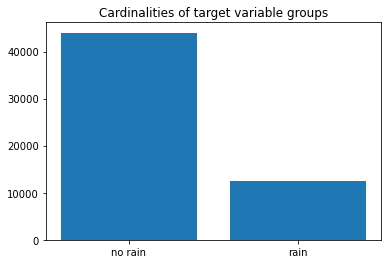

In [6]:
groups_cardinality_df = rain_df.groupby("RainTomorrow").size().reset_index(name="cardinality")

fig, axes = plt.subplots(1, 1)
axes.bar(groups_cardinality_df["RainTomorrow"], height=groups_cardinality_df["cardinality"])
axes.set_xticks([0, 1])
axes.set_xticklabels(["no rain", "rain"])
axes.set_title("Cardinalities of target variable groups")
plt.show()
# target raczej nie jest zrównoważony

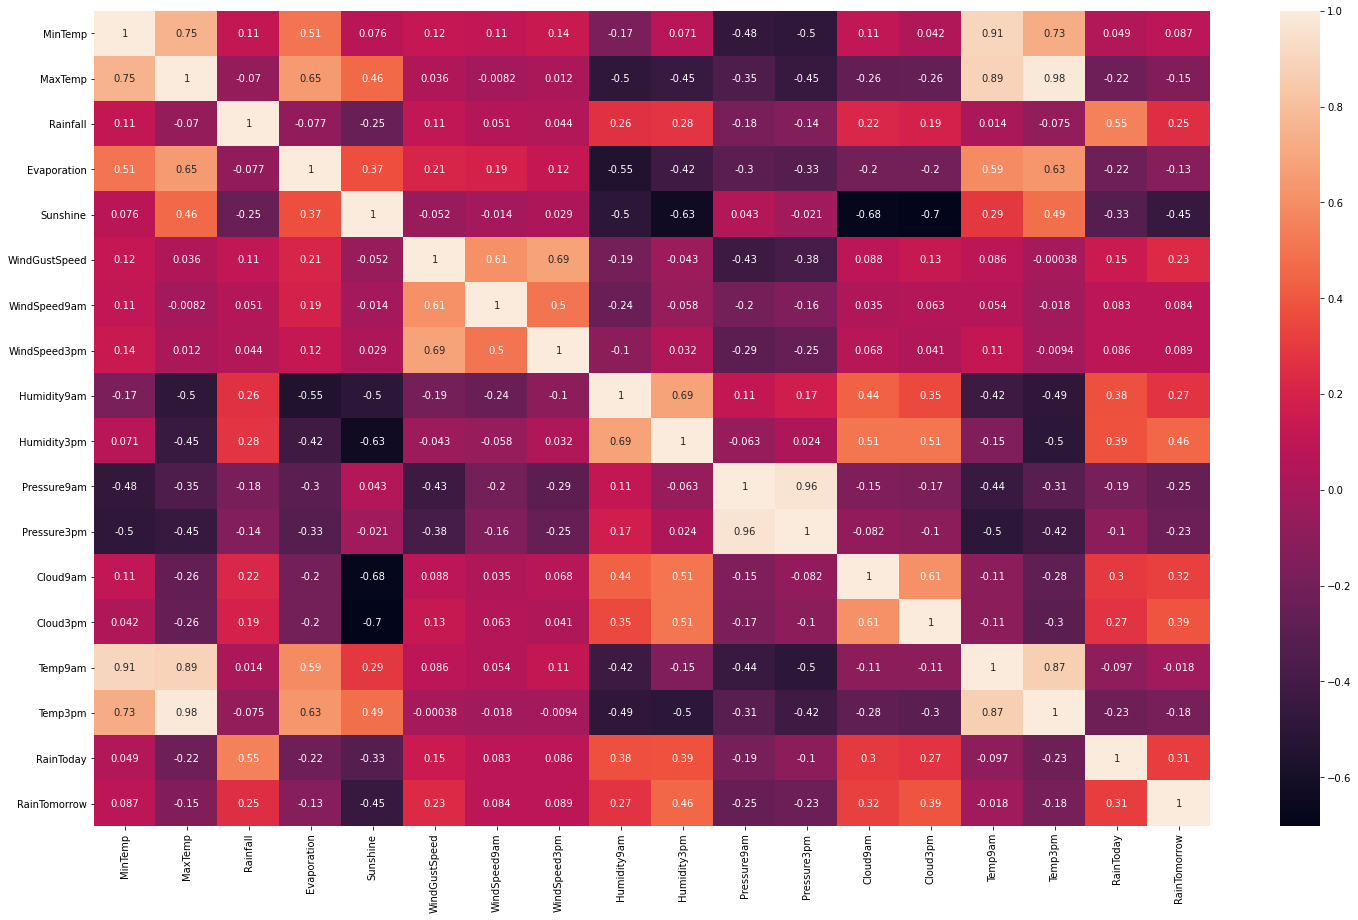

In [7]:
plt.figure(figsize=(25,15))
corr = rain_df.corr()
sns.heatmap(corr, annot=True)
plt.show()

## Modelling and scoring

In [8]:
# ze skorelowanych par odrzucamy po jednej kolumnie
X_train, X_test, y_train, y_test = train_test_split(rain_df.drop(["RainTomorrow", "MinTemp", "MaxTemp", "Temp9am", "Sunshine"], 
                                                                 axis=1), 
                                                    rain_df["RainTomorrow"], 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    stratify=rain_df["RainTomorrow"],
                                                    random_state=42)

In [9]:
def get_stats(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    
    print(f"F1-score: {f1_score(y_test, y_pred):.6f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_pred):.6f}")
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"Precision: {tp/(tp + fp):.2f}")
    print(f"Recall: {tp/(tp + fn):.2f}")
    print(f"Accuracy: {(tp + tn)/(tp + tn + fp + fn):.2f}")

In [10]:
# skalujemy dla regresji
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Wykorzystane miary to:
- F1-score, precision, recall
- Matthews Correlation Coefficient(MCC)
- AUC
- accuracy

Ostatnia pozycja była w tym przypadku trochę mniej ważna, ze względu na niezrównoważenie zmiennej targetowej.

### Dummy classifier
Na początku zobaczmy jak poradzi sobie model losowy, aby wiedzieć, czy reszta modeli w ogóle ma sens.

In [11]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
get_stats(dummy_clf, X_test, y_test)
# porównując te statystyki z pozostałymi widzimy, że pozostałe modele wypadają dużo lepiej, więc mają sens

F1-score: 0.213730
MCC: -0.008441
Precision: 0.21
Recall: 0.21
Accuracy: 0.65


### Logistic regression
Wybrane hiperparametry:
- penalty: l1; aby unknąć overfittingu
- solver: liblinear; jeden z lepszych algorytmów uczących do wykorzystania z karą l1
- class_weight: balanced; automatycznie dobiera wagi do klas targetu

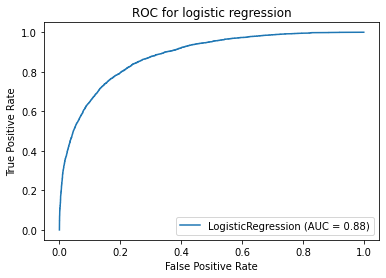

In [12]:
lr = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter = 100, random_state=0)
lr.fit(X_train, y_train)

metrics.plot_roc_curve(lr, X_test, y_test)
plt.title("ROC for logistic regression")
plt.show()

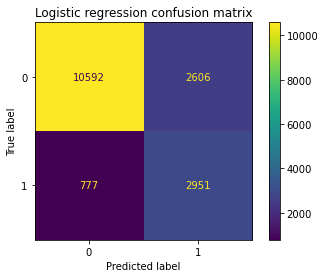

In [13]:
plot_confusion_matrix(lr, X_test, y_test)
plt.title("Logistic regression confusion matrix")
plt.show()

In [14]:
get_stats(lr, X_test, y_test)

F1-score: 0.635649
MCC: 0.524309
Precision: 0.53
Recall: 0.79
Accuracy: 0.80


### Random forest
Wybrane hiperparametry:
- max_depth: 20; określa maksymalną głębokość drzew w lesie, jest ważne dla uniknięcia overfittingu
- n_estimators: 200; ilość drzew w lesie, ustawienie zbyt dużej wartości może skutkować bardzo długim procesem uczenia

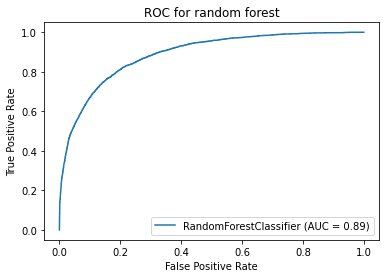

In [15]:
rfc = RandomForestClassifier(max_depth=20, n_estimators=200, random_state=0)
rfc.fit(X_train, y_train)

metrics.plot_roc_curve(rfc, X_test, y_test)
plt.title("ROC for random forest")
plt.show()

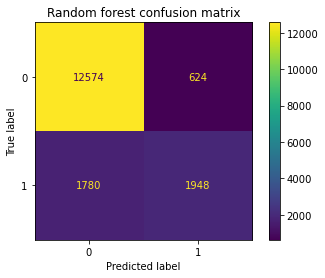

In [16]:
plot_confusion_matrix(rfc, X_test, y_test)
plt.title("Random forest confusion matrix")
plt.show()

In [17]:
get_stats(rfc, X_test, y_test)

F1-score: 0.618413
MCC: 0.548649
Precision: 0.76
Recall: 0.52
Accuracy: 0.86


### Gradient boosting
Wybrane hiperparametry:
- n_estimators: 50; liczba iteracji algorytmu
- learning_rate: 0.3; waga decyzji każdego dodanego drzewa, wybranie zbyt małej wartości może prowadzić do underfittingu
- max_depth: 8; maksymalna głębokość każdego drzewa

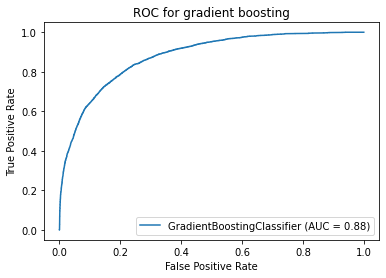

In [18]:
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.3, max_depth=8, random_state=0)
gbc.fit(X_train, y_train)

metrics.plot_roc_curve(gbc, X_test, y_test)
plt.title("ROC for gradient boosting")
plt.show()

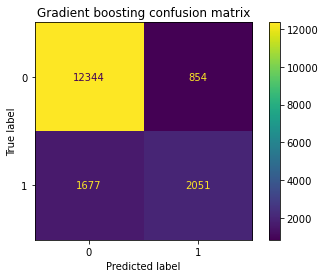

In [19]:
plot_confusion_matrix(gbc, X_test, y_test)
plt.title("Gradient boosting confusion matrix")
plt.show()

In [20]:
get_stats(gbc, X_test, y_test)

F1-score: 0.618423
MCC: 0.533553
Precision: 0.71
Recall: 0.55
Accuracy: 0.85


## Conclusion

Wszystkie klasyfikatory osiągnęły bardzo podobne(i nie najlepsze) wyniki. `Logistic regression` dobrze rozpoznał większość deszczy(wysoki `recall`), ale przewidując deszcz często się mylił(niski `precision`). Ostatecznie zaś, udało się temu klasyfikatorowi uzyskać najlepszy `F1-score`. Klasyfikatory drzewiaste, czyli `random forest` i `gradient boosting`, mieli podobne do siebie wyniki: obaj osiągnęli gorszy `F1-score`, za to mieli lepsze `MCC` i `accuracy`. Podsumowując, najlepszym klasyfikatorem został, moim zdaniem, `random forest`, miał bowiem  jednak lepsze wyniki od `gradient boosting`, a niski `F1-score` da się może poprawić poprzez dobranie lepszych hiperparametrów.